In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def cvtToPos(feat_map): # feat_map = [cx, cy, w, h]
    left_upper_x = feat_map[0] - int(feat_map[2]/2)
    left_upper_y = feat_map[1] - int(feat_map[3]/2)
    right_lower_x = feat_map[0] + int(feat_map[2]/2)
    right_lower_y = feat_map[1] + int(feat_map[3]/2)
    return np.array([left_upper_x, left_upper_y, right_lower_x, right_lower_y]).astype(np.int32)

def cvtEdge2Center(rect): # rect = [left_upper_x, left_upper_y, w, h]
    cx = rect[0] + int(rect[2]/2)
    cy = rect[1] + int(rect[3]/2)
    return np.array([cx, cy, rect[2], rect[3]]).astype(np.int32)

In [3]:
# compute feature map positions
def generate_feature_map(imgage_size, feat_size): # #(width, height),(m,n)
    im_w = imgage_size[0]
    im_h = imgage_size[1]
    w = im_w / feat_size[0]
    h = im_h / feat_size[1]

    feat_w = int(w)
    feat_h =int(h)

    feat_map = np.ones([feat_size[0], feat_size[1], 4])

    for i in range(feat_size[0]):
        for j in range(feat_size[1]):

            feat_c_x = int(w / 2 + 1 + i * w)
            feat_c_y = int(h / 2 + 1 + j * h)

            feat_map[i,j,:] = np.array((feat_c_x, feat_c_y, feat_w, feat_h))
        
    return feat_map.astype(np.int32)#(cx, cy, w, h) 

In [4]:
def generate_scales(smin, smax, num_map):
    return smin + (smax - smin) / (num_map - 1) * np.array([k for k in range(num_map+1)])

In [5]:
def generate_default_boxes(imgage_size, feat_map, feat_aspect, scale): #scale = (sk[i], sk[i+1])
    length = imgage_size[0]

    def_boxes = []

    for feat in feat_map:
        for j, ar in enumerate(feat_aspects[i]):
            if ar == 1:
                sk1 = [(scale[0] * scale[1]) ** 0.5, scale[0]]
                for sk in sk1:
                    w = int(length * sk * ar **0.5)
                    h = int(length * sk * (1/ar) ** 0.5)
                    def_boxes.append([feat[0],feat[1], w, h])
            else:
                    w = int(length * scale[0] * ar **0.5)
                    h = int(length * scale[0] * (1/ar) ** 0.5)
                    def_boxes.append([feat[0],feat[1], w, h])
    return np.array(def_boxes) 

In [6]:
def normalize(target, ref): # ref might be default box
    cx = (target[0] - ref[0]) / ref[2]
    cy = (target[1] - ref[1]) / ref[3]
    w = np.log(target[2]/ref[2])
    h = np.log(target[3]/ref[3])
    return np.array([cx, cy, w,h])

def smoothL1(target, ref):
    diffs = target - ref
    for m in range(4):
        if np.abs(diffs[m]) > 1:
            diffs[m] = np.abs(diffs[m])  -  0.5
        else:
            diffs[m] = 0.5 *np.abs(diffs[m]) ** 2
    return diffs.sum()

In [7]:
def box_area(box): #box = [cx, cy, w, h]
    return box[2] * box[3]

def intersection(tar_box, ref_box):# todo: when indexes are out of range
    pixels = 0
    ref_area = cvtToPos(ref_box) # pos = (xmin, ymin, xmax, ymax)
    tar_area = cvtToPos(tar_box)
    
    x_min_max = np.maximum(ref_area[0], tar_area[0])
    x_max_min = np.minimum(ref_area[2], tar_area[2])
    
    intersection_x = np.maximum(0, x_max_min - x_min_max)
    
    y_min_max = np.maximum(ref_area[1], tar_area[1])
    y_max_min = np.minimum(ref_area[3], tar_area[3])
    
    intersection_y = np.maximum(0, y_max_min - y_min_max)
    
    pixels = intersection_x * intersection_y

    return pixels

def IoU(tar_box, ref_box):
    return intersection(tar_box, ref_box)/(box_area(tar_box) + box_area(ref_box))

In [8]:
image_path = 'DSCN2112.JPG'
#image_path = 'test.jpg'
image = Image.open(image_path)
print(image.format, image.size, image.mode)

JPEG (4608, 3456) RGB


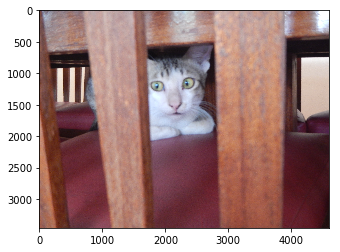

In [9]:
im_original = cv2.imread(image_path)
im_original = cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB)
plt.imshow(im_original)

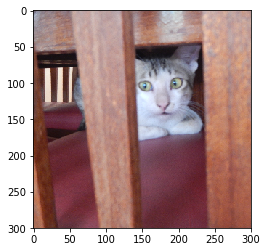

In [10]:
im_size = (300, 300)
x = 100
y = 0
w = min(im_original.shape[0:2])
h = min(im_original.shape[0:2])
im = im_original[y:y+h, x:x+w]
im = cv2.resize(im, im_size)
plt.imshow(im)

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Flatten
from keras.layers import merge
from keras.layers import Reshape
from keras.layers import Activation
from keras.layers import concatenate

C:\Users\Ryoji Nomura\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
# define IO shapes
input_shape = (300, 300, 3)
num_classes = 3

In [13]:
## root model
net = {}

# Input
net['inputs'] = Input(shape=input_shape, name='input')

# Block 1
net['conv1_1'] = Conv2D(64, (3, 3),activation='relu',padding='same',name='conv1_1',input_shape=input_shape)(net['inputs'])
net['conv1_2'] = Conv2D(64, (3, 3),activation='relu',padding='same',name='conv1_2')(net['conv1_1'])
net['pool1'] = MaxPooling2D((2,2),strides=(2,2),padding='same',name='pool1')(net['conv1_2'])

# # Block 2
net['conv2_1'] = Conv2D(128, (3, 3),activation='relu',padding='same',name='conv2_1')(net['pool1'])
net['conv2_2'] = Conv2D(128, (3, 3),activation='relu',padding='same',name='conv2_2')(net['conv2_1'])
net['pool2'] = MaxPooling2D((2, 2), strides=(2, 2), padding='same',name='pool2')(net['conv2_2'])

# # FC3
net['fc3'] = Conv2D(1024, (3, 3), dilation_rate=(6, 6),activation='relu', padding='same',name='fc3')(net['pool2'])

# # FC4
net['fc4'] = Conv2D(1024, (1, 1), activation='relu',padding='same',name='fc4')(net['fc3'])

# # Block 5
net['conv5_1'] = Conv2D(128, (3, 3),activation='relu',padding='same',name='conv5_1')(net['fc4'])
net['pool5'] = MaxPooling2D((2, 2), strides=(2, 2), padding='same',name='pool5')(net['conv5_1'])

# # Block 6
net['conv6_1'] = Conv2D(128, (3, 3),activation='relu',padding='same',name='conv6_1')(net['pool5'])
net['pool6'] = MaxPooling2D((2, 2), strides=(2, 2), padding='same',name='pool6')(net['conv6_1'])

# # Last Pool
net['pool7'] = GlobalAveragePooling2D(name='pool7')(net['pool6'])
net['dence8'] = Dense(num_classes, activation='softmax', name='dence8')(net['pool7'] )

model = Model(input=net['inputs'], output=net['dence8'])

C:\Users\Ryoji Nomura\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 300, 300, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 300, 300, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 300, 300, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 150, 150, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 150, 150, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 150, 150, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 75, 75, 128)       0         
__________

In [15]:
## branch model for feature map

dim_box = 4

num_priors = 6
net['conv5_1_mbox_loc'] = Conv2D(num_priors*dim_box,(3,3),padding='same',name='conv5_1_mbox_loc')(net['conv5_1'])
net['conv5_1_mbox_loc_flat'] = Flatten(name='conv5_1_mbox_loc_flat')(net['conv5_1_mbox_loc'])

net['conv5_1_mbox_conf'] = Conv2D(num_priors*num_classes,(3,3),padding='same',name='conv5_1_mbox_conf')(net['conv5_1'])
net['conv5_1_mbox_conf_flat'] = Flatten(name='conv5_1_mbox_conf_flat')(net['conv5_1_mbox_conf'])

net['pool6_mbox_loc'] = Conv2D(num_priors*dim_box,(3,3),padding='same',name='pool6_mbox_loc')(net['pool6'])
net['pool6_mbox_loc_flat'] = Flatten(name='pool6_mbox_loc_flat')(net['pool6_mbox_loc'])

net['pool6_mbox_conf'] = Conv2D(num_priors*num_classes,(3,3),padding='same',name='pool6_mbox_conf')(net['pool6'])
net['pool6_mbox_conf_flat'] = Flatten(name='pool6_mbox_conf_flat')(net['pool6_mbox_conf'])

# priorbox = PriorBox(img_size, 60.0, max_size=114.0, aspect_ratios=[2, 3],
#                     variances=[0.1, 0.1, 0.2, 0.2],
#                     name='conv5_1_mbox_priorbox')

# net['conv5_1_mbox_priorbox'] = priorbox(net['conv5_1'])

net['mbox_loc'] = concatenate([net['conv5_1_mbox_loc_flat'], net['pool6_mbox_loc_flat']], name='mbox_loc')
net['mbox_conf'] = concatenate([net['conv5_1_mbox_conf_flat'],net['pool6_mbox_conf_flat']],name='mbox_conf')
# net['mbox_conf'] = concatenate([net['conv5_1_mbox_priorbox'],net['pool6_mbox_priorbox']],name='mbox_conf')

net['mbox_loc'] = Reshape((-1, dim_box),name='mbox_loc_final')(net['mbox_loc'])
net['mbox_conf'] = Reshape((-1, num_classes),name='mbox_conf_logits')(net['mbox_conf'])
net['mbox_conf'] = Activation('softmax',name='mbox_conf_final')(net['mbox_conf'])
net['predictions'] = concatenate([net['mbox_loc'], net['mbox_conf']], name='predictions')

# net['predictions'] = concatenate([net['mbox_loc'], net['mbox_conf'], net['mbox_priorbox']], name='predictions')

model_feature_map = Model(input=net['inputs'], output=net['predictions'])

C:\Users\Ryoji Nomura\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`


In [16]:
model_feature_map.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 300, 300, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 300, 300, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 150, 150, 64) 0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

In [17]:
import keras.backend as K
K.int_shape(net['pool6_mbox_conf'])

(None, 19, 19, 18)

In [18]:
from ssd_layer import DefaultBox

In [19]:
# model.layers[6].output_shape
# model.predict(im.reshape([1,300,300,3]))
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])

In [20]:
boxes = DefaultBox(input_shape, 20, 30, [1], 0.1)

In [21]:
boxes(net['pool6_mbox_conf'])

<tf.Tensor 'default_box_1/ExpandDims:0' shape=(1, 361, 8) dtype=float32>